In [1]:
import pandas as pd, numpy as np
import seaborn as sns, matplotlib.pyplot as plt
import scipy

# Scenario 1: Correlation between intervention selection factors and its influence on proportion of the population eligible for the intervention (and therefore the *population-level* impact of the intervention)

Assume two dichotomous risks that are 100% assoicated with intervention (presence of R1 and R2 necessary to receive intervention).

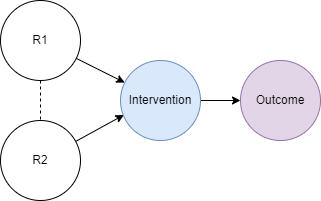

Note that the bias associated with failing to consider the correlation between R1 and R2 in this case affects the proportion of the population eligible for the intervention - therefore, this bias may not be a concern if the outcome will be stratified by intervention coverage.

In [2]:
"""
Calculates absolute and relative error in the proportion of the population eligible for
a hypothetical intervention under the assumption that the presence of both R1 and R2 dichotomous
risks is required for intervention eligibility and an assumed measure of correlation (rho).

Absolute error is defined as eligible population proportion without considering correlation minus
the population proportion with correlation considered.

Relative error is defined as the absolute error divided by the eligible population proportion with
correlation considered.
"""

def calculate_bias_dichotomous_risks(r1_exposure,
                                      r2_exposure,
                                      rho,
                                      N):
    np.random.seed(1)
    probit_propensity = np.random.multivariate_normal([0,0], [[1, rho], [rho, 1]], size=N)
    propensity = scipy.stats.norm().cdf(probit_propensity)

    df = pd.DataFrame(index=range(N))
    df['risk1_propensity'] = propensity[:,0]
    df['risk2_propensity'] = propensity[:,1]
    df['risk1_exposure'] = np.where(df.risk1_propensity <= r1_exposure, 1, 0)
    df['risk2_exposure'] = np.where(df.risk2_propensity <= r2_exposure, 1, 0)
    
    uncorrelated_eligibility = r1_exposure * r2_exposure
    correlated_eligibility = len(df.loc[(df.risk1_exposure==1)&(df.risk2_exposure==1)]) / len(df)
    
    absolute_bias = uncorrelated_eligibility - correlated_eligibility
    relative_bias = absolute_bias / correlated_eligibility
    
    return absolute_bias, relative_bias

Text(0.5, 0, 'R1 exposure')

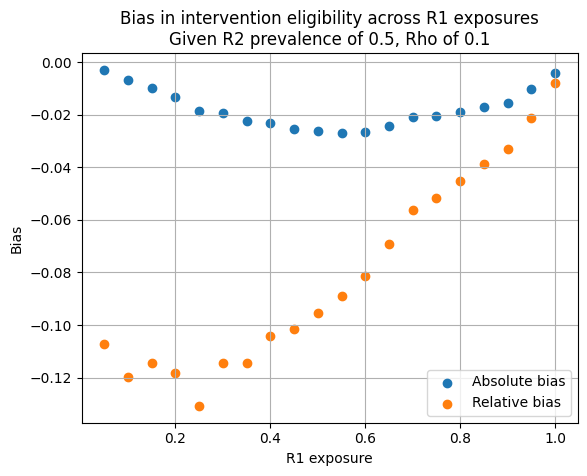

In [3]:
val = 0.05
vals = [val]
while vals[len(vals) - 1] < 1:
    vals.append(vals[len(vals)-1] + val)

plt.figure()
for exp in vals:
    absolute_bias, relative_bias = calculate_bias_dichotomous_risks(exp, 0.5, 0.1, 10_000)
    plt.scatter(exp, absolute_bias, color='tab:blue')
    plt.scatter(exp, relative_bias, color='tab:orange')
plt.grid()
plt.title('Bias in intervention eligibility across R1 exposures\nGiven R2 prevalence of 0.5, Rho of 0.1')
plt.legend(['Absolute bias','Relative bias'])
plt.ylabel('Bias')
plt.xlabel('R1 exposure')

Text(0.5, 0, 'R1 exposure')

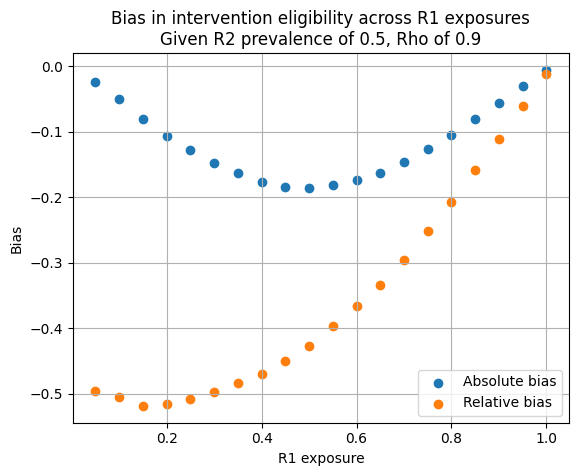

In [4]:
plt.figure()
for exp in vals:
    absolute_bias, relative_bias = calculate_bias_dichotomous_risks(exp, 0.5, 0.9, 10_000)
    plt.scatter(exp, absolute_bias, color='tab:blue')
    plt.scatter(exp, relative_bias, color='tab:orange')
plt.grid()
plt.title('Bias in intervention eligibility across R1 exposures\nGiven R2 prevalence of 0.5, Rho of 0.9')
plt.legend(['Absolute bias','Relative bias'])
plt.ylabel('Bias')
plt.xlabel('R1 exposure')

/tmp/ipykernel_1813248/2114921152.py:18: RuntimeWarning: covariance is not positive-semidefinite.
  probit_propensity = np.random.multivariate_normal([0,0], [[1, rho], [rho, 1]], size=N)


Text(0.5, 0, 'Rho')

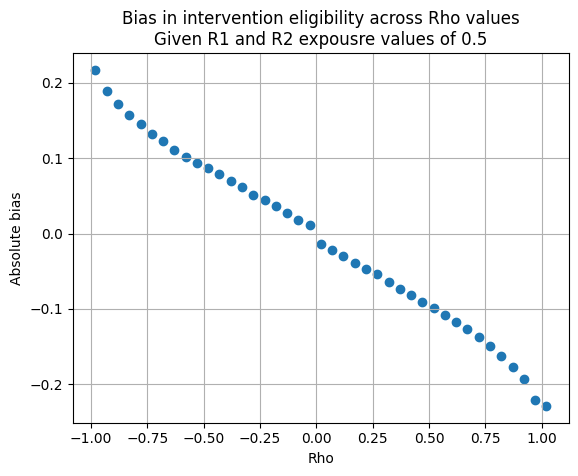

In [5]:
val = 0.05

vals = [-0.98]
while vals[len(vals) - 1] < 1:
    vals.append(vals[len(vals)-1] + val)

plt.figure()
for exp in vals:
    absolute_bias, relative_bias = calculate_bias_dichotomous_risks(0.5, 0.5, exp, 10_000)
    plt.scatter(exp, absolute_bias, color='tab:blue')
    #plt.scatter(exp, relative_bias, color='tab:orange')
plt.grid()
plt.title('Bias in intervention eligibility across Rho values\nGiven R1 and R2 expousre values of 0.5')
#plt.legend(['Absolute bias','Relative bias'])
plt.ylabel('Absolute bias')
plt.xlabel('Rho')

/tmp/ipykernel_1813248/2114921152.py:18: RuntimeWarning: covariance is not positive-semidefinite.
  probit_propensity = np.random.multivariate_normal([0,0], [[1, rho], [rho, 1]], size=N)


Text(0.5, 0, 'Rho')

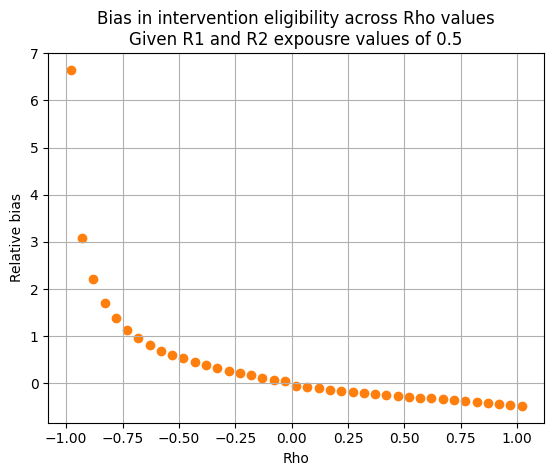

In [6]:
plt.figure()
for exp in vals:
    absolute_bias, relative_bias = calculate_bias_dichotomous_risks(0.5, 0.5, exp, 10_000)
    #plt.scatter(exp, absolute_bias, color='tab:blue')
    plt.scatter(exp, relative_bias, color='tab:orange')
plt.grid()
plt.title('Bias in intervention eligibility across Rho values\nGiven R1 and R2 expousre values of 0.5')
#plt.legend(['Absolute bias','Relative bias'])
plt.ylabel('Relative bias')
plt.xlabel('Rho')

In [7]:
# now for continuous risks
def calculate_bias_normal_risks(r1_mean, r1_sd, r1_threshold,
                                r2_mean, r2_sd, r2_threshold,
                                rho,
                                N):
    np.random.seed(1)
    probit_propensity = np.random.multivariate_normal([0,0], [[1, rho],
                                                         [rho, 1]], size=N)
    propensity = scipy.stats.norm().cdf(probit_propensity)

    df = pd.DataFrame(index=range(N))    
    df['risk1_exposure'] = scipy.stats.norm(r1_mean, r1_sd).ppf(propensity[:,0])
    df['risk2_exposure'] = scipy.stats.norm(r2_mean, r2_sd).ppf(propensity[:,0])
    uncorrelated_eligibility = (len(df.loc[df.risk1_exposure>=r1_threshold])/len(df)
                                * len(df.loc[df.risk2_exposure>=r2_threshold])/len(df))
    correlated_eligibility = len(df.loc[(df.risk1_exposure>=r1_threshold)
                                        &(df.risk2_exposure>=r2_threshold)]) / len(df)
    absolute_bias = uncorrelated_eligibility - correlated_eligibility
    relative_bias = absolute_bias / correlated_eligibility
    return absolute_bias, relative_bias

# Scenario 2: When the intervention targeting factor is associated with another risk of interest

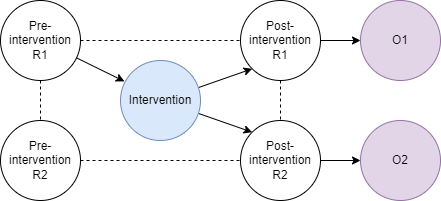

NOTE: for the sake of simplicity, we will assume that R1 and R2 do not affect the same outcome. This is because if R1 and R2 affected the same outcome we would need to calculate a joint PAF between R1 and R2 on the outcome, which would introduce additional sources of bias. Therefore, we will assess the impact of failing to consider the correlation between R1 and R2 demonstrated in the figure above on the intervention impact on the population average relative risk of R2 and its effect on O2 only (which should be proportionla to the intervention effect on O2)

Some applied examples:

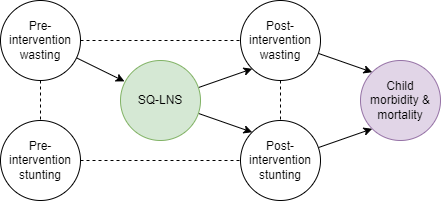

In this example of estimating the effect of SQ-LNS targeted to pre-intervention wasting state on child morbidity and mortality, failing to consider the correlation of pre-intervention wasting and stunting may bias the results.

and 
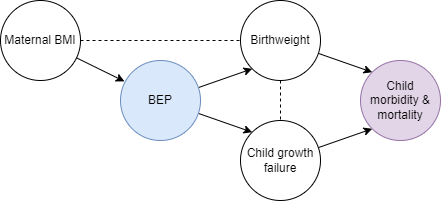

In this example of estimating the effect of antenatal balanced energy protein (BEP) supplementation targeted to maternal BMI status (which is associated with infant birth weight), failing to consider the association between birth weight and child growth failure may bias the results.

In [8]:
"""
Calculates absolute and relative error in the change in pre and post intervention
population average R2 relative risk for outcome O2 in the diagram above, assuming
R1 and R2 are dichotomour risk factors with the
defined values for R1 exposure, R2 exposure, correlation between R1 and R2 (rho), 
and the intervention effect on R2 (probability that intervention will change exposure
status of R2 from exposed to unexposed given intervention elibility (R1 exposure))

Absolute error is defined as the difference in pre- and post-intervention population
average R2 relative risk while failing to consider R1 and R2 correlation and while 
considering the R1 and R2 correlation, as a proportion of the difference while considering
the R1 and R2 correlation.

Relative error is defined as the difference in the in post-intervention population
average R2 relative risk as a fraction of the pre-intervention value in while failing 
to consider R1 and R2 correlation and considering the R1 and R2 correlation, 
as a proportion of the difference while considering
the R1 and R2 correlation.
"""
# note that the absolute scale is what we typically measure for "cases averted" due to an intervention


def scenario_3_dichotomous_risks(r1_exp, r2_exp, rho, int_r2_rr, N):
    np.random.seed(1)
    df = pd.DataFrame(index=range(N))
    probit_propensity = np.random.multivariate_normal([0,0], [[1, rho],
                                                         [rho, 1]], size=N)
    propensity = scipy.stats.norm().cdf(probit_propensity)
    df['r1_pre'] = np.where(propensity[:,0] <= r1_exp, 1, 0)
    df['intervention_effect_propensity'] = np.random.uniform(0, 1, size=len(df))
    df['r2_pre_correlated'] = np.where(propensity[:,1] <= r2_exp, 1, 0)
    df['r2_post_correlated'] = np.where((df.r1_pre==1) & (df.intervention_effect_propensity >= int_r2_rr),
                                        0, df.r2_pre_correlated)
    np.random.shuffle(propensity[:,1]) 
    intervention_effect_propensities = df.intervention_effect_propensity.values
    np.random.shuffle(intervention_effect_propensities)
    df['intervention_effect_propensity'] = intervention_effect_propensities
    df['r2_pre_uncorrelated'] = np.where(propensity[:,1] <= r2_exp, 1, 0)
    df['r2_post_uncorrelated'] = np.where((df.r1_pre==1) & (df.intervention_effect_propensity >= int_r2_rr),
                                        0, df.r2_pre_uncorrelated)

    for measure in ['correlated','uncorrelated']:
        df[f'abs_change_{measure}'] = df[f'r2_pre_{measure}'].mean() - df[f'r2_post_{measure}'].mean() # prevalence diff
        df[f'rel_change_{measure}'] = df[f'r2_post_{measure}'].mean() / df[f'r2_pre_{measure}'].mean() #

    abs_bias_pct = (df.abs_change_uncorrelated.mean() - df.abs_change_correlated.mean()) / df.abs_change_correlated.mean()
    rel_bias_pct = (df.rel_change_correlated.mean() - df.rel_change_uncorrelated.mean())# / df.rel_change_correlated.mean()

    return abs_bias_pct, rel_bias_pct

In [9]:
# default parameter values
r1_exp=0.5
r2_exp=0.5
rho=0.5
int_r2_rr=0.5
N=1_000_000

In [10]:
scenario_3_dichotomous_risks(r1_exp=r1_exp, 
                             r2_exp=r2_exp, 
                             rho=rho, 
                             int_r2_rr=int_r2_rr, 
                             N=N)

# bias on absolute and relative scales

(-0.2512614307801082, -0.08380704531644712)

In [11]:
scenario_3_dichotomous_risks(r1_exp=1, # effectively removes influence of targeting
                             r2_exp=r2_exp, 
                             rho=rho, 
                             int_r2_rr=int_r2_rr, 
                             N=N)

# no bias if not targeting
# small bias here due to randomness

(0.0005523048722886117, 0.0002758322939645508)

Text(0.5, 0, 'R1 exposure')

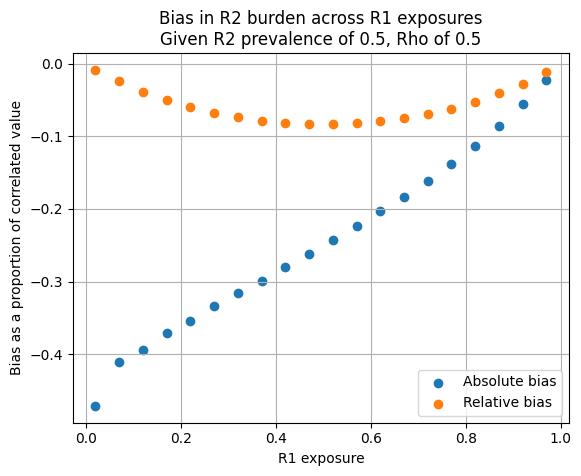

In [12]:
plt.figure()
for val in [val for val in vals if val > 0 and val < 1]:
    result = scenario_3_dichotomous_risks(r1_exp=val, 
                             r2_exp=r2_exp, 
                             rho=rho, 
                             int_r2_rr=int_r2_rr, 
                             N=N)
    plt.scatter(val, result[0], color='tab:blue')
    plt.scatter(val, result[1], color='tab:orange')
plt.grid()
plt.title('Bias in R2 burden across R1 exposures\nGiven R2 prevalence of 0.5, Rho of 0.5')
plt.legend(['Absolute bias','Relative bias'])
plt.ylabel('Bias as a proportion of correlated value')
plt.xlabel('R1 exposure')

Text(0.5, 0, 'R2 exposure')

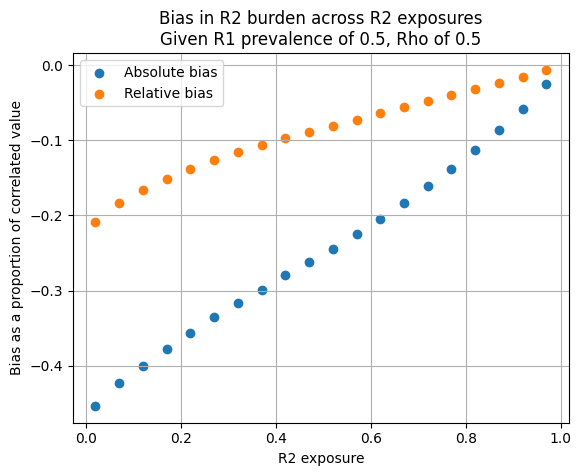

In [13]:
plt.figure()
for val in [val for val in vals if val > 0 and val < 1]:
    result = scenario_3_dichotomous_risks(r1_exp=r1_exp, 
                             r2_exp=val, 
                             rho=rho, 
                             int_r2_rr=int_r2_rr, 
                             N=N)
    plt.scatter(val, result[0], color='tab:blue')
    plt.scatter(val, result[1], color='tab:orange')
plt.grid()
plt.title('Bias in R2 burden across R2 exposures\nGiven R1 prevalence of 0.5, Rho of 0.5')
plt.legend(['Absolute bias','Relative bias'])
plt.ylabel('Bias as a proportion of correlated value')
plt.xlabel('R2 exposure')

/tmp/ipykernel_1813248/2466002026.py:26: RuntimeWarning: covariance is not positive-semidefinite.
  probit_propensity = np.random.multivariate_normal([0,0], [[1, rho],


Text(0.5, 0, 'Rho')

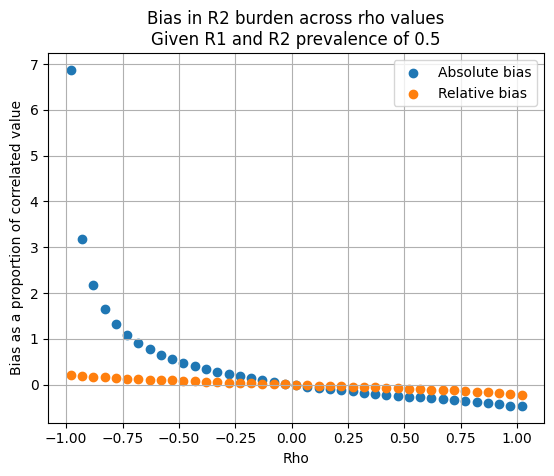

In [14]:
plt.figure()
for val in vals:
    result = scenario_3_dichotomous_risks(r1_exp=r1_exp, 
                             r2_exp=r2_exp, 
                             rho=val, 
                             int_r2_rr=int_r2_rr, 
                             N=N)
    plt.scatter(val, result[0], color='tab:blue')
    plt.scatter(val, result[1], color='tab:orange')
plt.grid()
plt.title('Bias in R2 burden across rho values\nGiven R1 and R2 prevalence of 0.5')
plt.legend(['Absolute bias','Relative bias'])
plt.ylabel('Bias as a proportion of correlated value')
plt.xlabel('Rho')

In [15]:
"""
Calculates absolute and relative error in the change in pre and post intervention
population average R2 relative risk for outcome O2 in the diagram above, assuming
R1 and R2 are continuous, normally-distributed risk factors with the
defined input parameter values

Absolute error is defined as the difference in pre- and post-intervention population
average R2 relative risk while failing to consider R1 and R2 correlation and while 
considering the R1 and R2 correlation, as a proportion of the difference while considering
the R1 and R2 correlation.

Relative error is defined as the difference in the in post-intervention population
average R2 relative risk as a fraction of the pre-intervention value in while failing 
to consider R1 and R2 correlation and considering the R1 and R2 correlation, 
as a proportion of the difference while considering
the R1 and R2 correlation.
"""

def scenario_2_continuous_risks(r1_mean, 
                                r1_sd, 
                                r2_mean, 
                                r2_sd, 
                                r2_tmrel, # for effect on O2
                                r2_rr, # for effect on O2
                                rho, # between R1 and R2
                               
                               r2_delta, # intervention mean difference on R2 exposure
                               r1_threshold, # those with exposure greater than threshold get intervention
                               
                               N):
    np.random.seed(1)
    df = pd.DataFrame(index=range(N))
    probit_propensity = np.random.multivariate_normal([0,0], [[1, rho],
                                                         [rho, 1]], size=N)
    propensity = scipy.stats.norm().cdf(probit_propensity)
    df['r1_pre'] = scipy.stats.norm(r1_mean, r1_sd).ppf(propensity[:,0])
    df['r2_pre_correlated'] = scipy.stats.norm(r2_mean, r2_sd).ppf(propensity[:,1])
    r2_propensities_shuffled = propensity[:,1]
    np.random.shuffle(r2_propensities_shuffled) 
    # shuffling propensities rather than randomly resampling to ensure exactly the same marginal R2 exposure distribution
    df['r2_pre_uncorrelated'] = scipy.stats.norm(r2_mean, r2_sd).ppf(r2_propensities_shuffled)
    for measure in ['correlated','uncorrelated']:
        df[f'r2_rr_pre_{measure}'] = (r2_rr ** ((df[f'r2_pre_{measure}'] - r2_tmrel 
                                        + abs(df[f'r2_pre_{measure}'] - r2_tmrel)) / 2))       
        df[f'r2_post_{measure}'] = np.where(df.r1_pre >= r1_threshold, 
                                            df[f'r2_pre_{measure}'] - r2_delta, 
                                            df[f'r2_pre_{measure}'])
        df[f'r2_rr_post_{measure}'] = (r2_rr ** ((df[f'r2_post_{measure}'] - r2_tmrel 
                                                  + abs(df[f'r2_post_{measure}'] - r2_tmrel)) / 2))
        
        df[f'abs_change_{measure}'] = df[f'r2_rr_pre_{measure}'] - df[f'r2_rr_post_{measure}']    
        df[f'rel_change_{measure}'] = df[f'abs_change_{measure}'] / df[f'r2_rr_pre_{measure}']
    
    abs_bias_percent = (df.abs_change_uncorrelated.mean() - df.abs_change_correlated.mean()) / df.abs_change_correlated.mean()
    rel_bias_percent = (df.rel_change_uncorrelated.mean() - df.rel_change_correlated.mean()) / df.rel_change_correlated.mean()
    
    return abs_bias_percent, rel_bias_percent

In [16]:
# define default parameters

r1_mean=10 
r1_sd=2 

r2_mean=10 
r2_sd=2 
r2_tmrel=8 
r2_rr=1.2

rho=0.5

r1_delta=2 
r2_delta=2
r1_threshold=10

N=100000 

In [17]:
scenario_2_continuous_risks(r1_mean=r1_mean, 
                            r1_sd=r1_sd, 
                            r2_mean=r1_mean, 
                            r2_sd=r2_sd, 
                            r2_tmrel=r2_tmrel, 
                            r2_rr=r2_rr,
                            rho=rho,
                            r2_delta=r2_delta,
                            r1_threshold=r1_threshold,
                            N=N)

# -22% bias in average R2 post-intervention relative risk on the absolute scale
# -17% bias in the average R2 post-intervention relative risk on the relative scale

(-0.22390138201102683, -0.17101025742251078)

In [18]:
# if we set risk TMRELs to zero (below the minimum observed value), we effectively
# create a linear risk effect (with no functional TMREL category)

scenario_2_continuous_risks(r1_mean=r1_mean, 
                            r1_sd=r1_sd, 
                            r2_mean=r1_mean, 
                            r2_sd=r2_sd, 
                            r2_tmrel=0, # set to zero to make risk effect linear
                            r2_rr=r2_rr,
                            rho=rho,
                            r2_delta=r2_delta,
                            r1_threshold=r1_threshold,
                            N=N)

# in this case, there is bias in the average post-intervention R2 RR on the absolute, but not relative scale

(-0.12872566218643477, -5.599725730370758e-06)

In [19]:
# Setting the R1 targeting threshold to zero (below the minimum observed exposure value)
# effectively removes targeting and the entire population receives the intervention

scenario_2_continuous_risks(r1_mean=r1_mean, 
                            r1_sd=r1_sd, 
                            r2_mean=r1_mean, 
                            r2_sd=r2_sd, 
                            r2_tmrel=r2_tmrel, 
                            r2_rr=r2_rr,
                            rho=rho, 
                            r2_delta=r2_delta,
                            r1_threshold=0, # set to zero to remove targeting influence
                            N=N)

# in this case, there is no bias associated with the average post-intervention R2 RR on the absolute or relative scales

(1.4707084383502162e-16, -1.3102300600037905e-16)

# Scenario 3: When correlated risks affect the same outcome

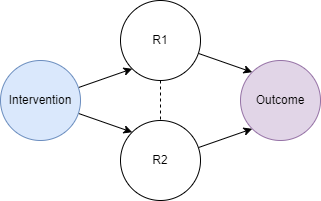

Note that GBD does not consider correlation in aggregate PAFs for two risks that impact the same outcome and accepts the bias associated with this limitation. However, the bias due to the failure to consider correlation between such risks on the impact of the intervention may be greater than the bias on the PAF and may no longer be of an acceptable magnitude and therefore should be investigated by researchers

In [20]:
# define default parameters

r1_mean=10 
r1_sd=2 
r1_tmrel=8 
r1_rr=1.2

r2_mean=10 
r2_sd=2 
r2_tmrel=8 
r2_rr=1.2

rho=-0.8

r1_delta=2 
r2_delta=2
r1_threshold=10

N=1_000_000 

O_rate = 0.2

In [21]:
"""
Calculates absolute error in the PAF and in cases of the outcome averted as if we fail 
to consider correlation between R1 and R2 as a proportion of the PAF and cases averted
estimates when correlation is considered. Calculation performed under the assumption of
the given input parameter values and continuous normal distributions of R1 and R2.
"""

def calculate_paf_and_cases_averted_bias(r1_mean,
                                        r1_sd,
                                        r1_tmrel,
                                        r1_rr,
                                        
                                        r2_mean,
                                        r2_sd,
                                        r2_tmrel,
                                        r2_rr,
                                        
                                        rho,
                                        
                                        r1_delta,
                                        r2_delta,
                                        
                                        N,
                                        O_rate):
    np.random.seed(1)
    df = pd.DataFrame(index=range(N))
    probit_propensity = np.random.multivariate_normal([0,0], [[1, rho], [rho, 1]], size=N)
    propensity = scipy.stats.norm().cdf(probit_propensity)
    df['r1'] = scipy.stats.norm(r1_mean, r1_sd).ppf(propensity[:,0])
    df['r2_correlated'] = scipy.stats.norm(r2_mean, r2_sd).ppf(propensity[:,1])
    r2_propensities_shuffled = propensity[:,1]
    np.random.shuffle(r2_propensities_shuffled) 
    # shuffling propensities rather than randomly resampling to ensure exactly the same marginal R2 exposure distribution
    df['r2_uncorrelated'] = scipy.stats.norm(r2_mean, r2_sd).ppf(r2_propensities_shuffled)

    df['r1_rr'] = np.where(df.r1 < r1_tmrel, 1, r1_rr ** (df.r1 - r1_tmrel))
    df['r2_rr_correlated'] = np.where(df.r2_correlated < r2_tmrel, 1, r2_rr ** (df.r2_correlated - r2_tmrel))
    df['r2_rr_uncorrelated'] = np.where(df.r2_uncorrelated < r2_tmrel, 1, r2_rr ** (df.r2_uncorrelated - r2_tmrel))
    df['joint_rr_correlated'] = df.r1_rr * df.r2_rr_correlated
    df['joint_rr_uncorrelated'] = df.r1_rr * df.r2_rr_uncorrelated
    paf_correlated = (df.joint_rr_correlated.mean() - 1) / df.joint_rr_correlated.mean()
    paf_uncorrelated = (df.joint_rr_uncorrelated.mean() - 1) / df.joint_rr_uncorrelated.mean()
    paf_bias = (paf_uncorrelated - paf_correlated) / paf_correlated

    df['O_correlated'] = O_rate * (1 - paf_correlated) * df.joint_rr_correlated
    df['O_uncorrelated'] = O_rate * (1 - paf_uncorrelated) * df.joint_rr_uncorrelated

    df['r1'] = df.r1 - r1_delta
    df['r2_correlated'] = df.r2_correlated - r2_delta
    df['r2_uncorrelated'] = df.r2_uncorrelated - r2_delta

    df['r1_rr'] = np.where(df.r1 < r1_tmrel, 1, r1_rr ** (df.r1 - r1_tmrel))
    df['r2_rr_correlated'] = np.where(df.r2_correlated < r2_tmrel, 1, r2_rr ** (df.r2_correlated - r2_tmrel))
    df['r2_rr_uncorrelated'] = np.where(df.r2_uncorrelated < r2_tmrel, 1, r2_rr ** (df.r2_uncorrelated - r2_tmrel))

    df['joint_rr_correlated'] = df.r1_rr * df.r2_rr_correlated
    df['joint_rr_uncorrelated'] = df.r1_rr * df.r2_rr_uncorrelated
    df['O_correlated'] = O_rate * (1 - paf_correlated) * df.joint_rr_correlated
    df['O_uncorrelated'] = O_rate * (1 - paf_uncorrelated) * df.joint_rr_uncorrelated

    O_averted_correlated = O_rate - df.O_correlated.mean()
    O_averted_uncorrelated = O_rate - df.O_uncorrelated.mean()

    O_bias = (O_averted_uncorrelated - O_averted_correlated) / O_averted_correlated

    return paf_bias, O_bias

In [22]:
# define default parameters

r1_mean=10 
r1_sd=2 
r1_tmrel=8 
r1_rr=1.2

r2_mean=10 
r2_sd=2 
r2_tmrel=8 
r2_rr=1.2

rho= 0.8

r1_delta=2 
r2_delta=2
r1_threshold=10

N=1_000_000 

O_rate = 0.2

In [23]:
calculate_paf_and_cases_averted_bias(r1_mean,
                                        r1_sd,
                                        r1_tmrel,
                                        r1_rr,
                                        
                                        r2_mean,
                                        r2_sd,
                                        r2_tmrel,
                                        r2_rr,
                                        
                                        rho,
                                        
                                        r1_delta,
                                        r2_delta,
                                        
                                        N,
                                        O_rate)

# as discussed on the risk correlation page, in the presence of positive correlation
# between R1 and R2 and RRs>1 for the effects of R1 and R2 on O, we will always have a 
# net underestimate of the PAF.

# here, the PAF error is similar in magnitude to the error in the estimate of cases averted
    # however, that is not always the case

(-0.05699689521795421, -0.05463124727850567)

/tmp/ipykernel_1813248/3162777306.py:27: RuntimeWarning: covariance is not positive-semidefinite.
  probit_propensity = np.random.multivariate_normal([0,0], [[1, rho], [rho, 1]], size=N)


Text(0.5, 0, 'Rho')

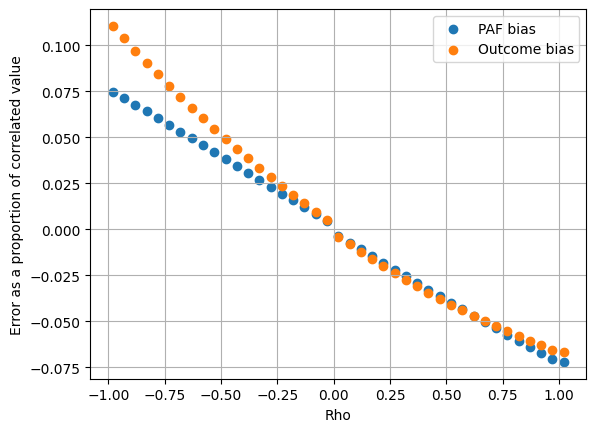

In [24]:
for val in vals:
    result = calculate_paf_and_cases_averted_bias(r1_mean,
                                        r1_sd,
                                        r1_tmrel,
                                        r1_rr,
                                        
                                        r2_mean,
                                        r2_sd,
                                        r2_tmrel,
                                        r2_rr,
                                        
                                        val,
                                        
                                        r1_delta,
                                        r2_delta,
                                                  
                                        N=10_000,
                                        O_rate=0.1)
    plt.scatter(val, result[0], color='tab:blue')
    plt.scatter(val, result[1], color='tab:orange')
plt.grid()
plt.legend(['PAF bias','Outcome bias'])
plt.ylabel('Error as a proportion of correlated value')
plt.xlabel('Rho')

Text(0.5, 0, 'R1 delta')

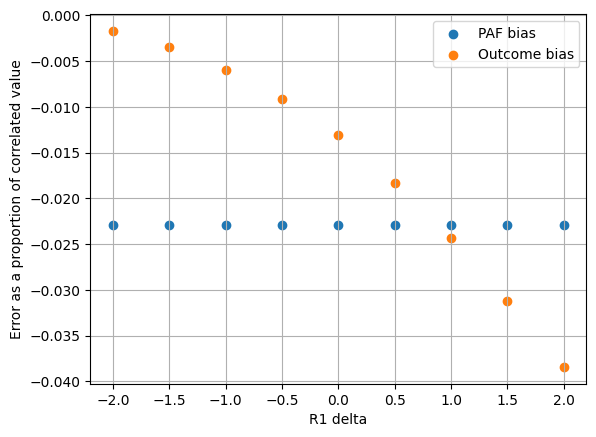

In [25]:
for val in [-2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2]:
    result = calculate_paf_and_cases_averted_bias(r1_mean=10,
                                        r1_sd=2,
                                        r1_tmrel=8,
                                        r1_rr=1.1,
                                        
                                        r2_mean=10,
                                        r2_sd=2,
                                        r2_tmrel=8,
                                        r2_rr=1.5,
                                        
                                        rho=0.5,
                                        
                                        r1_delta=val,
                                        r2_delta=1,
                                                  
                                        N=10_000,
                                        O_rate=0.1)
    plt.scatter(val, result[0], color='tab:blue')
    plt.scatter(val, result[1], color='tab:orange')
plt.grid()
plt.legend(['PAF bias','Outcome bias'])
plt.ylabel('Error as a proportion of correlated value')
plt.xlabel('R1 delta')

In [26]:
"""
Calculates absolute error in the PAF and in cases of the outcome averted as if we fail 
to consider correlation between R1 and R2 as a proportion of the PAF and cases averted
estimates when correlation is considered. Calculation performed under the assumption of
the given input parameter values and dichotomous R1 and R2 distributions.
"""

def calculate_paf_and_outcome_bias_dichotomous_risks(r1_exp, r1_rr, r2_exp, r2_rr, rho,
                                                    int_r1_rr, int_r2_rr, # defined as intervention influence
                                                                          # on population risk exposure
                                                     N, O_rate):
    np.random.seed(1)
    df = pd.DataFrame(index=range(N))
    probit_propensity = np.random.multivariate_normal([0,0], [[1, rho], [rho, 1]], size=N)
    propensity = scipy.stats.norm().cdf(probit_propensity)
    df['r1'] = np.where(propensity[:,0] <= r1_exp, 1, 0)
    df['r1_post'] = np.where(propensity[:,0] <= r1_exp * int_r1_rr, 1, 0)

    df['r2_correlated'] = np.where(propensity[:,1] <= r2_exp, 1, 0)
    df['r2_correlated_post'] = np.where(propensity[:,1] <= r2_exp * int_r2_rr, 1, 0)
    r2_propensities_shuffled = propensity[:,1]
    np.random.shuffle(r2_propensities_shuffled) 
    # shuffling propensities rather than randomly resampling to ensure exactly the same marginal R2 exposure distribution
    df['r2_uncorrelated'] = np.where(r2_propensities_shuffled <= r2_exp, 1, 0)
    df['r2_uncorrelated_post'] = np.where(r2_propensities_shuffled <= r2_exp * int_r2_rr, 1, 0)

    df['r1_rr'] = np.where(df.r1 == 1, r1_rr, 1)
    df['r2_rr_correlated'] = np.where(df.r2_correlated == 1, r2_rr, 1)
    df['r2_rr_uncorrelated'] = np.where(df.r2_uncorrelated == 1, r2_rr, 1)
    df['joint_rr_correlated'] = df.r1_rr * df.r2_rr_correlated
    df['joint_rr_uncorrelated'] = df.r1_rr * df.r2_rr_uncorrelated
    paf_correlated = (df.joint_rr_correlated.mean() - 1) / df.joint_rr_correlated.mean()
    paf_uncorrelated = (df.joint_rr_uncorrelated.mean() - 1) / df.joint_rr_uncorrelated.mean()
    paf_bias = (paf_uncorrelated - paf_correlated) / paf_correlated

    df['O_correlated'] = O_rate * (1 - paf_correlated) * df.joint_rr_correlated
    df['O_uncorrelated'] = O_rate * (1 - paf_uncorrelated) * df.joint_rr_uncorrelated

    df['r1_rr'] = np.where(df.r1_post == 1, r1_rr, 1)
    df['r2_rr_correlated'] = np.where(df.r2_correlated_post == 1, r2_rr, 1)
    df['r2_rr_uncorrelated'] = np.where(df.r2_uncorrelated_post == 1, r2_rr, 1)

    df['joint_rr_correlated'] = df.r1_rr * df.r2_rr_correlated
    df['joint_rr_uncorrelated'] = df.r1_rr * df.r2_rr_uncorrelated
    df['O_correlated'] = O_rate * (1 - paf_correlated) * df.joint_rr_correlated
    df['O_uncorrelated'] = O_rate * (1 - paf_uncorrelated) * df.joint_rr_uncorrelated

    O_averted_correlated = O_rate - df.O_correlated.mean()
    O_averted_uncorrelated = O_rate - df.O_uncorrelated.mean()

    O_bias = (O_averted_uncorrelated - O_averted_correlated) / O_averted_correlated
    
    return paf_bias, O_bias

In [27]:
calculate_paf_and_outcome_bias_dichotomous_risks(r1_exp=0.5, r1_rr=2, r2_exp=0.5, r2_rr=2, rho=0.5,
                                                    int_r1_rr=0.7, int_r2_rr=0.7, N=10_000, O_rate=0.1)

(-0.02974428052960986, 0.005300371730865409)

In [28]:
calculate_paf_and_outcome_bias_dichotomous_risks(r1_exp=0.5, r1_rr=2, r2_exp=0.5, r2_rr=2, rho=0.9,
                                                    int_r1_rr=0.7, int_r2_rr=0.7, N=100_000, O_rate=0.1)

(-0.05519632342805266, 0.04176616278532241)

In [29]:
calculate_paf_and_outcome_bias_dichotomous_risks(r1_exp=0.5, r1_rr=2, r2_exp=0.5, r2_rr=2, rho=0.5,
                                                    int_r1_rr=0.7, int_r2_rr=0.7, N=100_000, O_rate=0.1)

(-0.02863045261964036, 0.014464916399186652)

In [30]:
calculate_paf_and_outcome_bias_dichotomous_risks(r1_exp=0.5, r1_rr=2, r2_exp=0.5, r2_rr=0.8, rho=0.5,
                                                    int_r1_rr=0.7, int_r2_rr=1, N=100_000, O_rate=0.1)

(0.038269590963760015, -0.0024818045062268575)

Text(0.5, 0, 'R1 exposure')

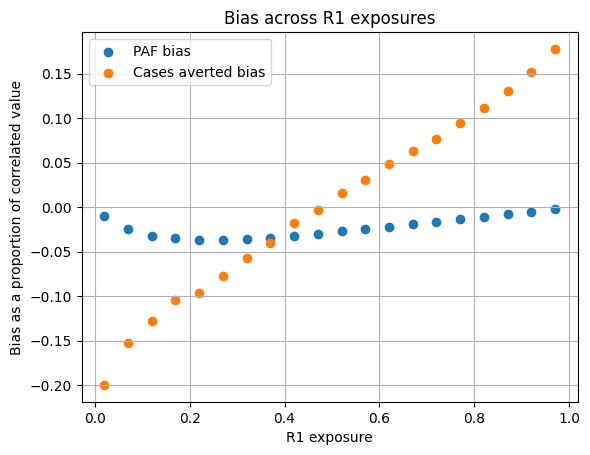

In [31]:
plt.figure()
for val in [val for val in vals if val > 0 and val < 1]:
    result = calculate_paf_and_outcome_bias_dichotomous_risks(r1_exp=val, r1_rr=2, r2_exp=0.5, r2_rr=2, rho=0.5,
                                                    int_r1_rr=0.7, int_r2_rr=1, N=100_000, O_rate=0.1)
    plt.scatter(val, result[0], color='tab:blue')
    plt.scatter(val, result[1], color='tab:orange')
plt.grid()
plt.title('Bias across R1 exposures')
plt.legend(['PAF bias','Cases averted bias'])
plt.ylabel('Bias as a proportion of correlated value')
plt.xlabel('R1 exposure')

/tmp/ipykernel_1813248/2012150924.py:14: RuntimeWarning: covariance is not positive-semidefinite.
  probit_propensity = np.random.multivariate_normal([0,0], [[1, rho], [rho, 1]], size=N)


Text(0.5, 0, 'Rho')

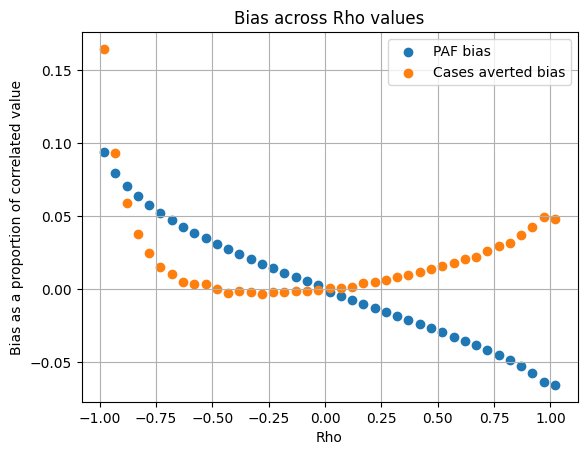

In [32]:
plt.figure()
for val in vals:# [val for val in vals if val > 0 and val < 1]:
    result = calculate_paf_and_outcome_bias_dichotomous_risks(r1_exp=0.5, r1_rr=2, r2_exp=0.5, r2_rr=2, rho=val,
                                                    int_r1_rr=0.7, int_r2_rr=0.7, N=100_000, O_rate=0.1)
    plt.scatter(val, result[0], color='tab:blue')
    plt.scatter(val, result[1], color='tab:orange')
plt.grid()
plt.title('Bias across Rho values')
plt.legend(['PAF bias','Cases averted bias'])
plt.ylabel('Bias as a proportion of correlated value')
plt.xlabel('Rho')